In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-2x_3eqot
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-2x_3eqot
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 688c7541d5e827ee159839026a35356ed3bc0bce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 9.2 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=880385 sha256=463fd3cf5adff9720d2a27c0f37a5379747148cfb2db4e6c98db8cbaa9133f69
  Stored in directory: /tmp/pip-ephem-wheel-cache-g75ctc3k/wheels/e5/8a/bc/10228fa47bb01dd916740a9102c063c4e363e7dac6d55dba4a
Successfully built torch-geometric
  Attempting uninst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 64.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.8 MB/s eta 0:00:00


In [ ]:
import os
import networkx as nx
import pandas as pd
import numpy as np
from torch_geometric.datasets import EllipticBitcoinDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from torch import nn
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score,roc_auc_score
import matplotlib
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

dataset = EllipticBitcoinDataset(root='./Elliptic')


Extracting Elliptic/raw/elliptic_txs_features.csv.zip
Extracting Elliptic/raw/elliptic_txs_edgelist.csv.zip
Extracting Elliptic/raw/elliptic_txs_classes.csv.zip
Processing...
Done!


In [ ]:
class DGI(torch.nn.Module):
    def __init__(self, n_in, n_h, activation):
        super(DGI, self).__init__()
        self.gcn = GCN(n_in, n_h, activation)
        self.read = AvgReadout()

        self.sigm = nn.Sigmoid()

        self.disc = Discriminator(n_h)

    def forward(self, seq1, seq2, adj, sparse, msk, samp_bias1, samp_bias2):
        h_1 = self.gcn(seq1, adj, sparse)

        c = self.read(h_1, msk)
        c = self.sigm(c)

        h_2 = self.gcn(seq2, adj, sparse)

        ret = self.disc(c, h_1, h_2, samp_bias1, samp_bias2)

        return ret

    # Detach the return variables
    def embed(self, seq, adj, sparse, msk):
        h_1 = self.gcn(seq, adj, sparse)
        c = self.read(h_1, msk)

        return h_1.detach(), c.detach()

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = torch.unsqueeze(c, 1)
        c_x = c_x.expand_as(h_pl)

        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 2)
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 2)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, seq, msk):
        if msk is None:
            return torch.mean(seq, 1)
        else:
            msk = torch.unsqueeze(msk, -1)
            return torch.sum(seq * msk, 1) / torch.sum(msk)

class GCN(torch.nn.Module):
    def __init__(self, in_ft, out_ft, act, bias=True):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft, bias=False)
        self.act = nn.PReLU() if act == 'prelu' else act
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_ft))
            self.bias.data.fill_(0.0)
        else:
            self.register_parameter('bias', None)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    # Shape of seq: (batch, nodes, features)
    def forward(self, seq, adj, sparse=False):
        seq_fts = self.fc(seq)
        if sparse:
            out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(seq_fts, 0)), 0)
        else:
            out = torch.bmm(adj, seq_fts)
        if self.bias is not None:
            out += self.bias
        
        return self.act(out)



In [ ]:
class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = self.fc(seq)
        return ret

In [ ]:
def check(name, unique):
    if(name not in unique):
        name = -1
    return name


def load_data(data_dir='./Elliptic/raw/', random_state=28):

    edges = pd.read_csv(data_dir + 'elliptic_txs_edgelist.csv')
    features = pd.read_csv(data_dir + 'elliptic_txs_features.csv', header=None)
    classes = pd.read_csv(data_dir + 'elliptic_txs_classes.csv')
    tx_features = ['tx_feat_' + str(i) for i in range(2, 95)]
    agg_features = ['agg_feat_' + str(i) for i in range(1, 73)]
    features.columns = ['txId', 'time_step'] + tx_features + agg_features
    features = pd.merge(
        features,
        classes,
        left_on='txId',
        right_on='txId',
        how='left')
    features = features[features['class'] != 'unknown']
    X_train, X_test, y_train, y_test = train_test_split(
        features, features['class'], stratify=features['class'], random_state=random_state, test_size=0.50)
    under_sampler = RandomUnderSampler(random_state=random_state)
    X_train, y_train = under_sampler.fit_resample(X_train, y_train)
    idx_train = range(len(X_train))
    idx_test = range(
        len(X_train),
        len(X_train) +
        len(X_test))
    features = pd.concat([X_train, X_test])
    unique = features['txId'].unique()
    edges['txId1'] = edges['txId1'].apply(lambda name: check(name, unique))
    edges['txId2'] = edges['txId2'].apply(lambda name: check(name, unique))
    edges = edges[edges['txId1'] != -1]
    edges = edges[edges['txId2'] != -1]
    class_values = sorted(features['class'].unique())
    features_idx = {
        name: idx for idx,
        name in enumerate(
            sorted(
                features['txId'].unique()))}
    class_idx = {name: id for id, name in enumerate(class_values)}
    features['txId'] = features['txId'].apply(lambda name: features_idx[name])
    edges['txId1'] = edges['txId1'].apply(lambda name: features_idx[name])
    edges['txId2'] = edges['txId2'].apply(lambda name: features_idx[name])
    features['class'] = features['class'].apply(lambda name: class_idx[name])
    labels = features['class']
    classes = sorted(list(set(labels)), reverse=False)
    classes_dict = {
        c: np.identity(
            len(classes))[
            i,
            :] for i,
        c in enumerate(classes)}
    labels = np.array(list(map(classes_dict.get, labels)), dtype=np.int32)
    idx_features_labels = features.values[:, :-1]
    features = sp.csr_matrix(idx_features_labels[:, 1:], dtype=np.float32)
    edges_unordered = edges.values
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(
        idx_features_labels.shape[0], idx_features_labels.shape[0]), dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    features = normalize_features(features)
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.FloatTensor(np.where(labels)[1])
    idx_train = torch.LongTensor(idx_train)
    idx_test = torch.LongTensor(idx_test)
    return adj, features, labels, idx_train, idx_test, X_train, X_test, y_train, y_test


def normalize_adj(mx):

    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    mx = mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)
    return mx


def normalize_features(mx):

    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [ ]:
batch_size = 1
nb_epochs = 1000
patience = 200
lr = 0.01
l2_coef = 0.001
hid_units = 256
sparse = True
nonlinearity = 'prelu'

In [ ]:
adj, features, labels, idx_train, idx_test, X_train, X_test, y_train, y_test = load_data()

In [ ]:
nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[0]


adj = normalize_adj(adj + sp.eye(adj.shape[0]))

if sparse:
    sp_adj = sparse_mx_to_torch_sparse_tensor(adj)
else:
    adj = (adj + sp.eye(adj.shape[0])).todense()

features = torch.FloatTensor(features[np.newaxis])
if not sparse:
    adj = torch.FloatTensor(adj[np.newaxis])
    
labels = torch.FloatTensor(labels[np.newaxis])
idx_train = torch.LongTensor(idx_train)
idx_test = torch.LongTensor(idx_test)

model = DGI(ft_size, hid_units, nonlinearity)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)

if torch.cuda.is_available():
    print('Using CUDA')
    model.cuda()
    features = features.cuda()
    if sparse:
        sp_adj = sp_adj.cuda()
    else:
        adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_test = idx_test.cuda()

b_xent = nn.BCEWithLogitsLoss()
xent = nn.CrossEntropyLoss()
cnt_wait = 0
best = 1e9
best_t = 0

Using CUDA


In [ ]:
for epoch in range(nb_epochs):
    model.train()
    optimiser.zero_grad()

    idx = np.random.permutation(nb_nodes)
    shuf_fts = features[:, idx, :]

    lbl_1 = torch.ones(batch_size, nb_nodes)
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    lbl = torch.cat((lbl_1, lbl_2), 1)

    if torch.cuda.is_available():
        shuf_fts = shuf_fts.cuda()
        lbl = lbl.cuda()
    
    logits = model(features, shuf_fts, sp_adj if sparse else adj, sparse, None, None, None) 

    loss = b_xent(logits, lbl)

    #print('Loss:', loss)

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), 'best_dgi.pkl')
    else:
        cnt_wait += 1

    if cnt_wait == patience:
        print('Early stopping!')
        break

    loss.backward()
    optimiser.step()

In [ ]:
model.load_state_dict(torch.load('best_dgi.pkl'))

embeds, _ = model.embed(features, sp_adj if sparse else adj, sparse, None)
train_embs = embeds[0, idx_train]
test_embs = embeds[0, idx_test]

train_lbls = labels[0, idx_train].type(torch.LongTensor)
test_lbls = labels[0, idx_test].type(torch.LongTensor)

train_lbls = train_lbls.cuda()
test_lbls = test_lbls.cuda()

In [ ]:
for _ in range(50):
    log = LogReg(hid_units, nb_classes)
    opt = torch.optim.Adam(log.parameters(), lr=0.01, weight_decay=0.0)
    log.cuda()

    pat_steps = 0
    best_acc = torch.zeros(1)
    best_acc = best_acc.cuda()
    for _ in range(100):
        log.train()
        opt.zero_grad()

        logits = log(train_embs)
        loss = xent(logits, train_lbls)
        
        loss.backward()
        opt.step()

    logits = log(test_embs)
    preds = torch.argmax(logits, dim=1)

Precision:  0.38049713193116635  Recall:  0.08758802816901408  F1:  0.14239713774597496


Text(0.5, 15.0, 'Predicted Labels')

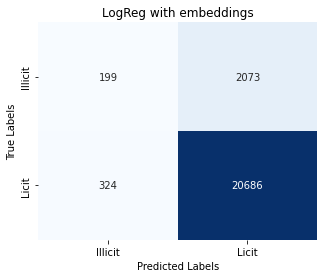

In [ ]:
F1 = f1_score(test_lbls.cpu(),preds.cpu(),pos_label=0)
Recall = recall_score(test_lbls.cpu(),preds.cpu(),pos_label=0)
Precision = precision_score(test_lbls.cpu(),preds.cpu(),pos_label=0)
cm = confusion_matrix(test_lbls.cpu(),preds.cpu())

print('Precision: ', Precision,' Recall: ', Recall, ' F1: ', F1)

cm_lbls = ['Illicit','Licit']
df_cm = pd.DataFrame(cm, index = cm_lbls ,
                  columns = cm_lbls)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True, cbar=False,cmap='Blues',fmt='g')
plt.title('LogReg with embeddings')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')


In [ ]:
y_train = np.array(y_train).astype(int)
y_test = np.array(y_test).astype(int)

X_train = X_train.drop('class',axis=1)
X_train = X_train.drop('txId',axis=1)
X_test = X_test.drop('class',axis=1)
X_test = X_test.drop('txId',axis=1)

In [ ]:
rfc= RFC(criterion = 'gini' , n_estimators = 200 , random_state = 28, max_features=None,bootstrap=True)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_features=None, n_estimators=200, random_state=28)

Precision:  0.7609841827768014  Recall:  0.9529049295774648  F1:  0.8461989446941567


Text(0.5, 15.0, 'Predicted Labels')

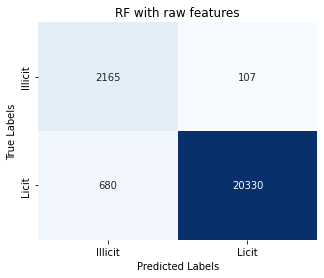

In [ ]:
pred = rfc.predict(X_test)
cm = confusion_matrix(y_test,pred)
F1 = f1_score(y_test,pred,pos_label=1)
Recall = recall_score(y_test,pred,pos_label=1)
Precision = precision_score(y_test,pred,pos_label=1)


print('Precision: ', Precision,' Recall: ', Recall, ' F1: ', F1)

cm_lbls = ['Illicit','Licit']
df_cm = pd.DataFrame(cm, index = cm_lbls ,
                  columns = cm_lbls)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True, cbar=False,cmap='Blues',fmt='g')
plt.title('RF with raw features')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')


In [ ]:
rfc.fit(train_embs.cpu(),train_lbls.cpu())

RandomForestClassifier(max_features=None, n_estimators=200, random_state=28)

Precision:  0.5687571921749137  Recall:  0.8701584507042254  F1:  0.6878914405010439


Text(0.5, 15.0, 'Predicted Labels')

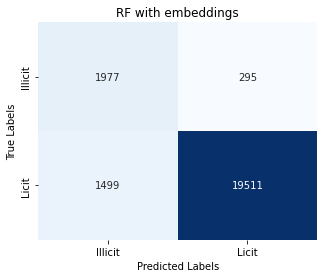

In [ ]:
pred_embs = rfc.predict(test_embs.cpu())
F1 = f1_score(test_lbls.cpu(),pred_embs,pos_label=0)
Recall = recall_score(test_lbls.cpu(),pred_embs,pos_label=0)
Precision = precision_score(test_lbls.cpu(),pred_embs,pos_label=0)
cm = confusion_matrix(test_lbls.cpu(),pred_embs)

print('Precision: ', Precision,' Recall: ', Recall, ' F1: ', F1)

cm_lbls = ['Illicit','Licit']
df_cm = pd.DataFrame(cm, index = cm_lbls ,
                  columns = cm_lbls)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True, cbar=False,cmap='Blues',fmt='g')
plt.title('RF with embeddings')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')


In [ ]:
tr_embs = pd.DataFrame(train_embs.cpu()).astype(float)
tst_embs = pd.DataFrame(test_embs.cpu()).astype(float)
X_train = pd.DataFrame(X_train).astype(float)
X_test = pd.DataFrame(X_test).astype(float)

In [ ]:
train_embs.index = X_train.index
new_train = pd.concat((X_train,tr_embs),axis=1)
tst_embs.index = X_test.index
new_test = pd.concat((X_test,tst_embs),axis=1)

new_train.columns = new_train.columns.astype(str)
new_test.columns = new_test.columns.astype(str)

In [ ]:
rfc.fit(new_train,y_train)

RandomForestClassifier(max_features=None, n_estimators=200, random_state=28)

Precision:  0.7995478522984175  Recall:  0.9339788732394366  F1:  0.8615509541209907


Text(0.5, 15.0, 'Predicted Labels')

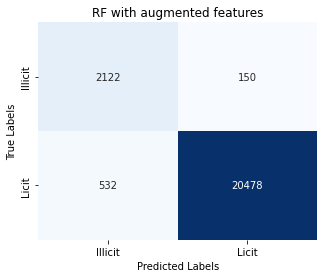

In [ ]:
pred = rfc.predict(new_test)
cm = confusion_matrix(y_test,pred)
F1 = f1_score(y_test,pred,pos_label=1)
Recall = recall_score(y_test,pred,pos_label=1)
Precision = precision_score(y_test,pred,pos_label=1)

print('Precision: ', Precision,' Recall: ', Recall, ' F1: ', F1)

cm_lbls = ['Illicit','Licit']
df_cm = pd.DataFrame(cm, index = cm_lbls ,
                  columns = cm_lbls)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm, annot=True, cbar=False,cmap='Blues',fmt='g')
plt.title('RF with augmented features')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
